<a href="https://colab.research.google.com/github/nyp-sit/aiup/blob/main/day1-pm/video-anomaly-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.nyp.edu.sg/content/dam/nyp/logo.png" width="238" height="70"/>



## Isolation Forest

We first generate some sample data in two clusters (each one containing n_samples) by randomly sampling the standard normal distribution as returned by numpy.random.randn. One of them is spherical and the other one is slightly deformed.

For consistency with the IsolationForest notation, the inliers (i.e. the gaussian clusters) are assigned a ground truth label 1 whereas the outliers (created with numpy.random.uniform) are assigned the label -1.

In [1]:
#import sys
#!{sys.executable} -m pip install scikit-learn==1.1.0
!pip install scikit-learn==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

n_samples, n_outliers = 120, 40
rng = np.random.RandomState(0)
covariance = np.array([[0.5, -0.1], [0.7, 0.4]])
cluster_1 = 0.4 * rng.randn(n_samples, 2) @ covariance + np.array([2, 2])  # general
cluster_2 = 0.3 * rng.randn(n_samples, 2) + np.array([-2, -2])  # spherical
outliers = rng.uniform(low=-4, high=4, size=(n_outliers, 2))

X = np.concatenate([cluster_1, cluster_2, outliers])
y = np.concatenate(
    [np.ones((2 * n_samples), dtype=int), -np.ones((n_outliers), dtype=int)]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

We can visualize the resulting clusters:

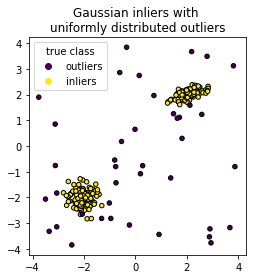

In [3]:
import matplotlib.pyplot as plt

scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
handles, labels = scatter.legend_elements()
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.title("Gaussian inliers with \nuniformly distributed outliers")
plt.show()

Next, we train the Isolation Forest with the default 100 estimators, default contamination and sub-sampling rate of 100.

In [4]:
from sklearn.ensemble import IsolationForest

#clf = IsolationForest(n_estimators=100, max_samples=100, contamination='auto', random_state=0)
clf = IsolationForest(n_estimators=1000, max_samples=100, contamination=0.2, random_state=0)
clf.fit(X_train)

IsolationForest(contamination=0.2, max_samples=100, n_estimators=1000,
                random_state=0)

We use the class DecisionBoundaryDisplay to visualize a discrete decision boundary. The background color represents whether a sample in that given area is predicted to be an outlier or not. The scatter plot displays the true labels.

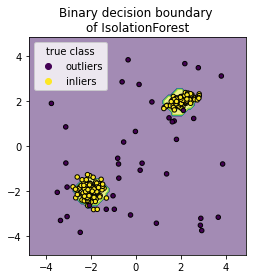

In [5]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.show()

By setting the response_method="decision_function", the background of the DecisionBoundaryDisplay represents the score given by the path length averaged over a forest of random trees.

When a forest of random trees collectively produce short path lengths for isolating some particular samples, they are highly likely to be anomalies and the measure of normality is close to 0. Similarly, large paths correspond to values close to 1 and are more likely to be inliers.

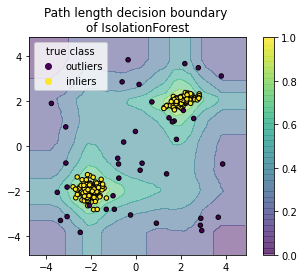

In [6]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Path length decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.colorbar(disp.ax_.collections[1])
plt.show()

## Exercise
Change the hyperparameters of the isolation forest and observe what happens to the decision boundaries

## Isolation Forest for Credit Card Fraud Detection

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest

df=pd.read_csv('creditcard.csv')
df.head

<bound method NDFrame.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.

Examine the data distribution. Most of the data are valid transactions, with only a small percentage of fraud cases

0    284315
1       492
Name: Class, dtype: int64


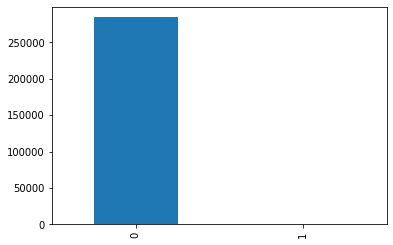

In [5]:
print(df.Class.value_counts())
df.Class.value_counts().plot(kind='bar')

As a first step, we can train the Isolation Forest using only the non-fraudulent class. For validation, we will use data from both fraudulent and non-fraudulent classes

In [6]:
seed = 1337
from sklearn.model_selection import train_test_split
def get_data(df, clean_train=True):
    """
        clean_train=True returns a train sample that only contains clean samples.
        Otherwise, it will return a subset of each class in train and test (10% outlier)
    """
    clean = df[df.Class == 0].copy().reset_index(drop=True)
    fraud = df[df.Class == 1].copy().reset_index(drop=True)
    print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

    if clean_train:
        train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
        print(f'Train Samples: {len(train)}')

        test = pd.concat([test_clean, fraud]).reset_index(drop=True)

        print(f'Test Samples: {len(test)}')

        # shuffle the test data
        test.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        train_X, train_y = train.loc[:, ~train.columns.isin(['Class'])], train.loc[:, train.columns.isin(['Class'])]
        test_X, test_y = test.loc[:, ~test.columns.isin(['Class'])], test.loc[:, test.columns.isin(['Class'])]
    else:
        clean_train, clean_test = train_test_split(clean, test_size=int(len(fraud)+(len(fraud)*0.9)), random_state=seed)
        fraud_train, fraud_test = train_test_split(fraud, test_size=int(len(fraud)*0.1), random_state=seed)
        print(len(clean_train))
        print(len(fraud_train))
        
        train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
        test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)
        
        # shuffle
        train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Train Samples: {len(train_samples)}')
        test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Test Samples: {len(test_samples)}')
        train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['Class'])], train_samples.loc[:, train_samples.columns.isin(['Class'])]
        test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['Class'])], test_samples.loc[:, test_samples.columns.isin(['Class'])]
    
    return train_X, train_y, test_X, test_y



In [7]:
train_X, train_y, test_X, test_y = get_data(df)

model = IsolationForest(random_state=seed)
#model.fit(train_X, train_y)
model.fit(train_X)

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283823
Test Samples: 984


IsolationForest(random_state=1337)

We can now make the predictions and print the classification report

In [8]:
from sklearn.metrics import classification_report
def predict(X):
    test_yhat = model.predict(X)
    # values are -1 and 1 (-1 for outliers and 1 for inliers), thus we will map it to 0 (inlier) and 1 (outlier) as this is our target variable
    test_yhat = np.array([1 if y == -1 else 0 for y in test_yhat])
    return test_yhat

test_yhat = predict(test_X)

In [9]:
def get_classification_report(test_y, test_yhat):
    labels = ['Legitimate','Fraudulent']
    print(classification_report(test_y, test_yhat, target_names=labels))
get_classification_report(test_y, test_yhat)

              precision    recall  f1-score   support

  Legitimate       0.86      0.96      0.90       492
  Fraudulent       0.95      0.84      0.89       492

    accuracy                           0.90       984
   macro avg       0.90      0.90      0.90       984
weighted avg       0.90      0.90      0.90       984



As seen in the classification report, the f1-score for fraudulent class is 0.89, which is quite good. Let us see what happens if our training data had both fraudulent and non-fraudeulent data

In [10]:
train_X, train_y, test_X, test_y = get_data(df, clean_train=False)
model = IsolationForest(random_state=seed)
#model.fit(train_X, train_y)
model.fit(train_X)
test_yhat = predict(test_X)

Clean Samples: 284315, Fraud Samples: 492
283381
443
Train Samples: 283824
Test Samples: 983


In [11]:
get_classification_report(test_y, test_yhat)

              precision    recall  f1-score   support

  Legitimate       0.99      0.97      0.98       934
  Fraudulent       0.57      0.80      0.67        49

    accuracy                           0.96       983
   macro avg       0.78      0.88      0.82       983
weighted avg       0.97      0.96      0.96       983



The f1-score for fraudulent cases has dropped to 0.67 although the f1-score for legitimate cases have increased. This indicates that the inclusion of the outliers in the training set has caused the threshold to better identify legitimate points, at the expense of the fraudulent cases.  

## DBSCAN

Let us now use DBSCAN for anomaly detection. Recall that DBSCAN is a density based clustering approach that clusters data points based on continuous regions of high point density and determines the ideal number of clusters to be formed. In contrast to k-means, not all points are assigned to a cluster, and we are not required to declare the number of clusters (k). However, the two key parameters in DBSCAN are min_samples (to set the minimum number of data points required to determine a core point) and eps (max allowed distance between two points to put them in the same cluster).

Lets first try a toy example

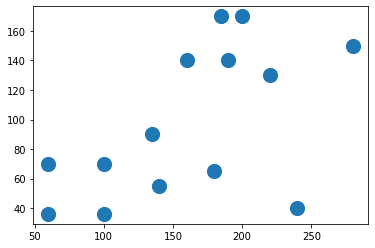

In [108]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.cluster import DBSCAN

X_train = np.array([[60,36], [100,36], [100,70], [60,70],
    [140,55], [135,90], [180,65], [240,40],
    [160,140], [190,140], [220,130], [280,150], 
    [200,170], [185, 170]])
plt.scatter(X_train[:,0], X_train[:,1], s=200)
plt.show()


We now use DBSCAN with eps=45 and min_samples=4 to perform anomaly detection. There are 6 core points found by the algorithm, 2 clusters and a couple of outliers (noise points).

In [111]:
eps = 45
min_samples = 4
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_train)
labels = db.labels_
print(labels)

print(db.core_sample_indices_)

[ 0  0  0  0  0  0  0 -1  1  1  1 -1  1  1]
[ 1  2  4  9 12 13]


We can visualize the clusters as below. Points in cluster 0 are colored red, points in cluster 1 are colored green, outlier points are colored black and core points are marked with '*'s. Two points are connected by an edge if they are within the epsilon neighbourhood.

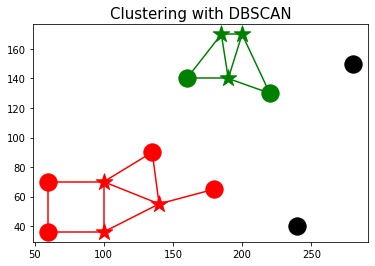

In [110]:
def dist(a, b):
    return np.sqrt(np.sum((a - b)**2))

colors = ['r', 'g', 'b', 'k']
for i in range(len(X_train)):
    plt.scatter(X_train[i,0], X_train[i,1], 
                s=300, color=colors[labels[i]], 
                marker=('*' if i in db.core_sample_indices_ else 'o'))
                                                            
    for j in range(i+1, len(X_train)):
        if dist(X_train[i], X_train[j])  < eps:
            plt.plot([X_train[i,0], X_train[j,0]], [X_train[i,1], X_train[j,1]], '-', color=colors[labels[i]])
            
plt.title('Clustering with DBSCAN', size=15)
plt.show()

## DBSCAN on credit card fraud dataset

We first scale and normalize the train_X data from above.

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

In [129]:
scaler=StandardScaler().fit(train_X)
X_s = scaler.transform(train_X)
X_norm = pd.DataFrame(normalize(X_s))
X_norm.head()


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.047923,-0.199858,-0.228628,0.020562,0.081671,0.199833,-0.148977,-0.232185,-0.159425,0.076901,...,-0.191547,-0.111462,-0.061123,-0.700008,0.093624,-0.112596,0.050545,0.343165,-0.132209,0.197213
1,0.125601,-0.012983,0.128775,0.161845,0.341916,0.114844,-0.014012,0.292576,-0.156117,-0.149150,...,-0.012650,-0.065504,-0.054826,0.013181,0.101599,-0.368021,-0.192784,-0.322410,-0.330967,-0.009318
2,0.297626,0.279410,0.007380,-0.394449,0.194308,0.240171,0.028446,0.129578,-0.039654,-0.030007,...,-0.032411,0.028282,0.113713,-0.061856,-0.084128,0.304277,-0.284711,-0.020196,-0.054116,-0.035148
3,-0.077527,0.052178,-0.172499,0.145528,0.030675,-0.164455,0.245195,-0.178383,0.091680,0.033375,...,-0.037658,-0.027016,0.028447,0.005331,-0.156770,-0.073167,0.224433,0.035282,0.029158,0.092937
4,-0.105592,0.200896,0.049005,0.031906,0.079263,0.048255,-0.003711,0.010641,-0.020050,-0.020782,...,-0.009898,-0.113932,-0.293155,0.024123,-0.376486,0.174320,0.110099,-0.004743,0.008913,-0.106792


We will fit the DBSCAN model using eps 0.65 and min_samples as 5. “labels” is a vector of the same length as the number of training samples. It contains the class index for each sample, indicating the class it was assigned to. Recall that anomalies have ‘-1’ as their class index.

In [130]:
db_model = DBSCAN (eps=0.65, min_samples=5).fit(X_norm)
labels=db_model.labels_
np.unique(labels)

array([-1,  0])

We can visualize a logarithmic histogram of the labels, and count the number of outliers identified

<function matplotlib.pyplot.show(*args, **kw)>

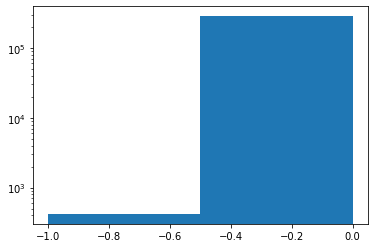

In [131]:
import matplotlib.pyplot as plt
plt.hist(labels, bins=len(np.unique(labels)),log=True)
plt.show

In [132]:
n_clusters=len(np.unique(labels))-1
anomaly=list(labels).count(-1)
print(f'Clusters: {n_clusters}')
print(f'Abnormal points: {anomaly}')

Clusters: 1
Abnormal points: 421


Let us check the accuracy of DBSCAN on the training set

In [134]:
labels2=np.array([1 if y == -1 else 0 for y in labels])
def get_classification_report(test_y, test_yhat):
    label_name = ['Legitimate','Fraudulent']
    print(classification_report(test_y, test_yhat, target_names=label_name))
get_classification_report(train_y, labels2)

              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    283381
  Fraudulent       0.01      0.01      0.01       443

    accuracy                           1.00    283824
   macro avg       0.50      0.50      0.50    283824
weighted avg       1.00      1.00      1.00    283824



The accuracy of DBSCAN doesn't seem good with the current parameters. Isolation Forest has a better performance. The anomalies detected by DBSCAN from this dataset are not the actual anomalies.

## Exercise

Try adjusting some of the parameters of DBSCAN and observe what happens

## Pycaret
Pycaret is an Automated Machine Learning (AutoML) tool that can be used for both supervised and unsupervised learning. It contains many anomaly detection models.

In [ ]:
!pip install pycaret==2.3.5
!pip install scipy==1.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will be performing anomaly detection on the Wisconsin Breast Cancer (Diagnostic) dataset from UCI Machine Learning Repository which contains features computed digitized image of a fine needle aspirate of a breast mass and the diagnosis if the mass is benign (B) or malignant (M). This dataset commonly used for demonstrating supervised machine learning where a model is trained to predict the diagnosis. For the purpose of demonstrating unsupervised anomaly detection, we will ignore the diagnosis. We first split the data into the training set and reserve a small “unseen” set for scoring.

In [36]:
from pycaret.anomaly import *
from sklearn.datasets import load_breast_cancer
df = load_breast_cancer(as_frame=True)['data']
df_train = df.iloc[:-10]
df_unseen = df.tail(10)

df_unseen.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
559,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,0.06570,...,12.48,37.16,82.28,474.2,0.12980,0.25170,0.3630,0.09653,0.2112,0.08732
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,...,15.30,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321
561,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,0.05502,...,11.92,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905
562,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,0.07152,...,17.52,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.23560,0.4089,0.14090
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,24.29,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.25420,0.2929,0.09873


Next, we will setup Pycaret to use the dataset. To use Pycaret, we will need to first call the setup function as below. Setting the silent parameter to True automatically confirms the input of data types when setup is executed. If silent is set to False, Pycaret requires the user to do manual confirmation of the input data types as shown in the image below.

In [ ]:
anom = setup(data = df_train, 
             silent = True)

,Description,Value
0,session_id,1594
1,Original Data,"(559, 30)"
2,Missing Values,False
3,Numeric Features,30
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(559, 30)"
9,CPU Jobs,-1


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='UNSUPERVISED_DUMMY_TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=Non...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
        

We can check the anomaly detection models available in Pycaret. The reference column indicates which source package the model was built from. 

In [ ]:
models()

INFO:logs:gpu_param set to False


,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


Next, we will train an anomaly detection model. Let's load the iforest model that we have seen previously, with fraction parameter = 0.05. The fraction parameter is the contamination parameter that we have seen previously and indicates the amount of outliers present in the dataset. It has a default value of 0.05

In [56]:
anom_model = create_model(model = 'iforest', fraction = 0.05)

INFO:logs:create_model_container: 3
INFO:logs:master_model_container: 3
INFO:logs:display_container: 4
INFO:logs:IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=1594, verbose=0)
INFO:logs:create_model() succesfully completed......................................


We can now train the model using the *assign_model* function. This scores the training dataset using the trained model and returns the prediction of the model, concatenated with the training data. The Anomaly column is binary where 1 indicates that the record is anomalous and 0 indicates that it is normal. The Anomaly_Score column gives the raw score for the record, where negative indicates that the record is normal.

In [57]:
results = assign_model(anom_model)

INFO:logs:Initializing assign_model()
INFO:logs:assign_model(model=IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=1594, verbose=0), transformation=False, score=True, verbose=True)
INFO:logs:Checking exceptions
INFO:logs:Determining Trained Model
INFO:logs:Trained Model : Isolation Forest
INFO:logs:Copying data
INFO:logs:(559, 32)
INFO:logs:assign_model() succesfully completed......................................


In [58]:
print(results)

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0         17.990         10.38          122.80     1001.0          0.11840   
1         20.570         17.77          132.90     1326.0          0.08474   
2         19.690         21.25          130.00     1203.0          0.10960   
3         11.420         20.38           77.58      386.1          0.14250   
4         20.290         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
554       12.880         28.92           82.50      514.3          0.08123   
555       10.290         27.61           65.67      321.4          0.09030   
556       10.160         19.59           64.73      311.7          0.10030   
557        9.423         27.88           59.26      271.3          0.08123   
558       14.590         22.68           96.39      657.1          0.08473   

     mean compactness  mean concavity  mean concave points  mea

We can visualize the high dimensional results in lower dimensions using data visualization non-linear graph based methods such as t-SNE or UMAP

In [59]:
plot_model(anom_model, plot = 'tsne')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [60]:
plot_model(anom_model, plot = 'umap')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


Finally, we can save the model, load the saved model and use it to make predictions 

In [61]:
save_model(model = anom_model, model_name = 'iforest_model')
loaded_model = load_model('iforest_model')
loaded_model.predict(df_unseen)

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=1594, verbose=0), model_name=iforest_model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='UNSUPERVISED_DUMMY_TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=Non...
                ('scaling', 'passthrough'), ('P_tra

Transformation Pipeline and Model Successfully Saved


INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=iforest_model, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

We can look also look at the probabilities, as well as the anomaly scores using the following functions respectively.

In [62]:
loaded_model.predict_proba(df_unseen)

array([[0.77383401, 0.22616599],
       [0.89916207, 0.10083793],
       [0.47670737, 0.52329263],
       [0.47385537, 0.52614463],
       [0.53946081, 0.46053919],
       [0.50067118, 0.49932882],
       [0.68264866, 0.31735134],
       [0.85376346, 0.14623654],
       [0.30544885, 0.69455115],
       [0.69041753, 0.30958247]])

In [63]:
loaded_model.decision_function(df_unseen)

array([-0.10612619, -0.14954957, -0.00317845, -0.00219029, -0.02492111,
       -0.01148137, -0.0745325 , -0.13381996,  0.0561588 , -0.07722425])

However, the results are not very accurate with the default fraction value

In [64]:
df2=load_breast_cancer(as_frame=True)['target']
df2_unseen = df2.tail(10)
print(df2_unseen)

559    1
560    1
561    1
562    0
563    0
564    0
565    0
566    0
567    0
568    1
Name: target, dtype: int64


## Exercise

1. Try changing the fraction/contamination value and see if the prediction accuracy increases. Discuss why or why not.
2. Try using the pycaret package on the credit card fraud dataset and vice versa